## Setup

In [1]:
%%capture
!pip install cirq

In [3]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

## Functions

Functions for generating circuits, noise models, folding, execution, ZNE methods, and plotting.

In [120]:
def generate_random_circuit(qubits=3, n_moments=3, op_density=1, random_state=11):
    return cirq.testing.random_circuit(qubits=qubits, n_moments=n_moments, op_density=op_density, random_state=random_state)

In [121]:
def depolarizing_noise_model(error_prob=0.01):
    noise_model = cirq.NoiseModel.from_noise_model_like(cirq.depolarize(p=error_prob))
    return noise_model

In [122]:
def apply_noise(circuit, noise_model):
    noisy_circuit = circuit.with_noise(noise_model)
    return noisy_circuit

In [123]:
def fold_circuit(circuit, num_folds=1):
    folded_circuit = cirq.Circuit()
    for i, moment in enumerate(circuit):
        for op in moment:
            folded_circuit.append(op)
            folded_circuit.append([cirq.inverse(op), op] * num_folds)
    return folded_circuit

In [124]:
def execute(circuit, noise_model=None):
    if noise_model:
        circuit = apply_noise(circuit, noise_model)
    dsim = cirq.DensityMatrixSimulator()
    rho = dsim.simulate(circuit).final_density_matrix
    return rho[0, 0].real

In [119]:
def zne(noisy_results, method='linear'):
    y = noisy_results
    x = np.arange(len(y))
    x = x + 1

    if method == 'linear':
        coefficients = np.polyfit(x, y, 1)
        zero_noise_limit = coefficients[1]
    elif method == 'polynomial':
        coefficients = np.polyfit(x, y, 2)
        zero_noise_limit = np.polyval(coefficients, len(y))
    elif method == 'exponential':
        coefficients = np.polyfit(x, np.log(y), 1)
        zero_noise_limit = np.exp(coefficients[1])

    return zero_noise_limit

In [118]:
def plot_results(results, degree=1):
    y = results
    x = np.arange(len(y)) + 1

    p = np.poly1d(np.polyfit(x, y, degree))
    t = np.linspace(0, len(y))

    # Plot points and trendline
    plt.plot(x, y, 'o')
    plt.plot(t, p(t), '--')

    # Calculate intersection with y-axis
    y_intercept = p(0)
    plt.plot(0, y_intercept, 'ko')

    plt.xticks(np.arange(0, max(x) + 1, 1))
    plt.yticks(np.arange(0.0, 1, 0.1))
    plt.legend(['Noisy Simulation Data', 'Extrapolation to Zero-Noise', f'Extrapolated Point at {y_intercept:.2f}'])
    plt.xlabel('Noise Level')
    plt.ylabel('Results')
    plt.title('Zero-Noise Extrapolation')
    plt.show()

## Testing

In [125]:
# Test: Generate random circuit
circuit = generate_random_circuit()
circuit

┌──┐
0: ───@───X─────×────
      │   │     │
1: ───@───┼────S┼────
          │     │
2: ───Z───@─────×────
              └──┘

In [126]:
# Test: Create depolarizing noise model
noise_model = depolarizing_noise_model(0.05)
noise_model

cirq.ConstantQubitNoiseModel(cirq.depolarize(p=0.05))

In [127]:
# Test: Apply folding to circuit
folded_circuit = fold_circuit(circuit, 1)
folded_circuit

┌──┐   ┌─────┐   ┌──┐
0: ───@───@───@────X──────X─────────X─────×───×───×───
      │   │   │    │      │         │     │   │   │
1: ───@───@───@────┼S─────┼S^-1─────┼S────┼───┼───┼───
                   │      │         │     │   │   │
2: ───Z───Z───Z────@──────@─────────@─────×───×───×───
                  └──┘   └─────┘   └──┘

In [129]:
# Test: Execute circuit with noisy simulation
noisy_result = execute(folded_circuit, noise_model)
noisy_result

0.4469934

## Complete Task

In [133]:
# Simulate circuit with noise model and folding to get unmitigated results
circuit = generate_random_circuit()
noise_model = depolarizing_noise_model(0.05)

ideal_result = execute(circuit)
noisy_result = execute(circuit, noise_model)

print(f"Ideal result: {ideal_result:.2f}\n")
print(f"Unmitigated noisy result: {noisy_result:.2f}\n")

num_folds = 3
noisy_results = []

for fold in range(num_folds):
    folded_circuit = fold_circuit(circuit, fold)
    result = execute(folded_circuit, noise_model)
    noisy_results.append(result)

mitigated_result = zne(noisy_results, method='linear')

print(f"ZNE mitigated result: {mitigated_result:.2f}\n")

print(f"Error mitigation: {(mitigated_result - noisy_result) / ideal_result * 100:.2f}%")

Ideal result: 1.00

Unmitigated noisy result: 0.74

ZNE mitigated result: 0.94

Error mitigation: 19.59%


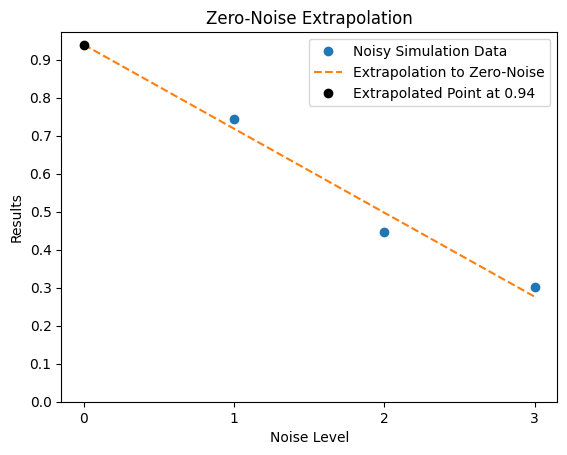

In [134]:
# Plot the noisy results and the ZNE value
plot_results(noisy_results, 1)